In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
from alphamind.api import *
from PyFin.api import *

from matplotlib import rc
from matplotlib import pyplot as plt

plt.style.use("seaborn-poster")
rc('font', **{'family': 'Microsoft Yahei', 'size': 10})
rc('mathtext', **{'default': 'regular'})
rc('legend', **{'frameon': False})

In [2]:
factor_name = 'EMA5D'
neutralized_styles = industry_styles
start_date = '2020-01-02'
end_date = '2020-02-21'
engine = SqlEngine(os.environ['DB_URI'])
universe_name = 'hs300'
freq = '10b'

In [3]:
factors = {'ROE': LAST(factor_name),
           'ROE_l1': SHIFT(LAST(factor_name), 1),
           'ROE_l2': SHIFT(LAST(factor_name), 2),
           'ROE_l3': SHIFT(LAST(factor_name), 3)}

factors_names = list(factors.keys())

In [4]:
universe = Universe(universe_name)
dates = makeSchedule(start_date, end_date, freq, calendar='china.sse')
factors = engine.fetch_factor_range(universe, factors, dates=dates)
risk_cov, risk_factors = engine.fetch_risk_model_range(universe, dates=dates)
dx_returns = engine.fetch_dx_return_range(universe, dates=dates, horizon=map_freq(freq))
total_data = pd.merge(factors, risk_factors, on=['trade_date', 'code'])
total_data = pd.merge(total_data, dx_returns, on=['trade_date', 'code'])
total_data.dropna(inplace=True)

In [5]:
neutralized_factors = neutralize(total_data[neutralized_styles].values.astype(float),
                                 total_data[factors_names].values,
                                 groups=total_data['trade_date'].values)
total_data[factors_names] = neutralized_factors

In [6]:
values = {}
for f in factors_names:
    ic_series = total_data.groupby('trade_date').apply(lambda x: np.corrcoef(x[f], x['dx'])[0, 1])
    values[f] = ic_series.mean()
values = pd.Series(values)

<AxesSubplot:>

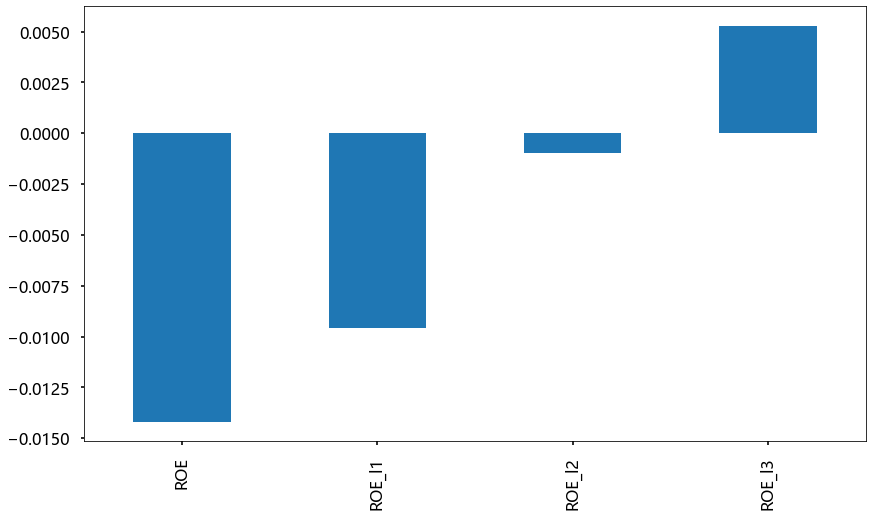

In [7]:
values.plot(kind='bar', figsize=(14, 8))